In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt
import scipy as sc
mpl.rcParams.update({'font.size':22})

# Progress bar yay
from ipywidgets import FloatProgress

# Physical Constants
phi0 = 2.067833831e-15
hbar = 1.054571800e-34
e = 1.6021766208e-19

## LZS Interference

When a qubit is driven periodically such that the avoided crossing is repeatidly crossed using a driving signal, successive Landau-Zener transitions interfere to give rise to so-called Stückelberg oscillations under the right conditions. Following [W. D. Weber *et al*][1], the spin-level Hamiltonian for this system is

$$\hat{H} = -\frac{1}{2}\left(\Delta \hat{\sigma}_x + \varepsilon(t)\hat{\sigma}_z\right)$$

where the Z bias term $\varepsilon(t)$ is driven by an RF source as follows:

$$\varepsilon(t) = \varepsilon_0 + A_\mathrm{RF} \sin(\omega t) \cdot$$

$\varepsilon_0$ is a static offset and $A_\mathrm{RF}$ is the RF energy amplitude. Together these parameters control the timing and number of crossings the system will experience when driven. To see LZS interference, the regime of interest is when

$$A_\mathrm{RF} > \varepsilon_0$$

such that there are two crossings within one period of the driving signal. The experiment consists of choosing a driving frequency $\omega$ and tunnel splitting $\Delta$ as fixed, and then varying the RF amplitude $A_\mathrm{RF}$ and offset $\varepsilon_0$. The state of the qubit is then readout and an excited state population inferred from repeated measurements at a given setpoint ($A_\mathrm{RF}$,$\varepsilon_0$). In practice an RF pulse of finite length is applied that guarantees sufficient crossings occur.

The LZS interference is an analog of Mach-Zehnder interference in phase space, where the beam path length difference in phase space (phase difference) is

$$\hbar \delta \theta_{1,2} = \int_{t_1}^{t_2} \varepsilon(t) dt$$

where $t_1$ and $t_2$ are the times at which the crossing is crossed within a period of the driving field. Over a whole period of the driving field, the total phase aggretated will be

$$\hbar \theta = \int_{0}^{\frac{2\pi}{\omega}} \varepsilon(t) dt = \frac{2\pi\varepsilon_0}{\omega}$$

where maximum constructive interference occurs when $\theta = 2\pi n$, which means we should expect to clearly see interference fringes at the values

$$\varepsilon_{0,n} = n \hbar \omega \cdot$$

Thus by sweeping $\varepsilon_0$ oscillations in the excited state population should be observed at these resonant points. Maximum destructive interference occurs when $\theta = \pi \left(2n + 1\right)$, so that we would expect to see no probability of finding the excited state (assuming $T=0$ $\mathrm{K}$) at the values:

$$\varepsilon_{0,n} = \left(n+\frac{1}{2}\right) \hbar \omega \cdot$$

### Small tunneling regime

We will first look at the situation studied experimentally by [W. D. Weber *et al*][1], where

$$\Delta \ll \omega, A_\mathrm{RF},\varepsilon_0$$

which, as we show below, leads to a slow evolution of the expectation values of $\hat{\sigma}_z$ at resonance.

#### Constructive interference

First looking at the evolution of the state during the RF pulse at the resonant point $\epsilon_{0,1} = \hbar \omega$, we see that for small values of $\Delta$, a pulse within a certain length needs to be applied to build a significant probability of being in the excited state:

[1]: http://science.sciencemag.org/content/310/5754/1653

In [3]:
# Hamiltonian parameters
delta0 = 0.01*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = epsilon0/1

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

ypts = []
delta_vals = [0.005*2*np.pi,0.01*2*np.pi,0.015*2*np.pi,0.02*2*np.pi]

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/len(delta_vals)
for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    times = np.linspace(0,50,1500)
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

Progress:


FloatProgress(value=0.0)

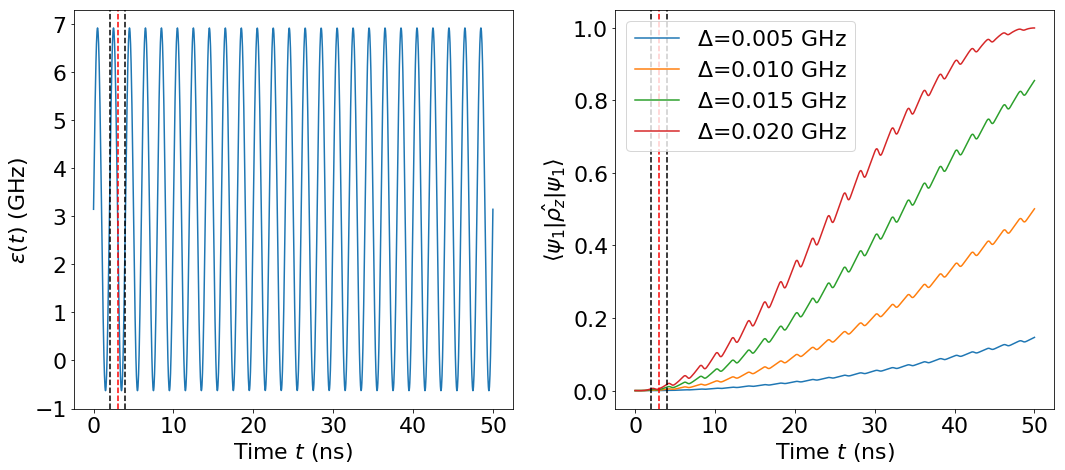

In [4]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# Epsilon term
ax1 = plt.subplot(121)
ax1.plot(times,epsilon(times,p))
ax1.axvline(x=2*np.pi/omega,ls="--",c="k")
ax1.axvline(x=3*np.pi/omega,ls="--",c="r")
ax1.axvline(x=4*np.pi/omega,ls="--",c="k")
#ax1.plot(xpts/tf_max,B(xpts,p))
ax1.set_xlabel('Time $t$ (ns)')
ax1.set_ylabel('$\epsilon (t)$ (GHz)')
#ax1.legend(("A(s)","B(s)"))

# Oscillations
ax2 = plt.subplot(122)
labels = []
for i in range(len(delta_vals)):
    ax2.plot(times, ypts[i])
    labels.append("$\\Delta$=%.3f GHz" % (delta_vals[i]/(2*np.pi)))
ax2.axvline(x=2*np.pi/omega,ls="--",c="k")
ax2.axvline(x=3*np.pi/omega,ls="--",c="r")
ax2.axvline(x=4*np.pi/omega,ls="--",c="k")
#ax2.plot(tf, pop0_ydm)
#ax2.plot(tf, pop0_xdm)
ax2.set_xlabel('Time $t$ (ns)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax2.legend(labels)

fig.tight_layout()

#### Destructive interference

Now we look at the evolution when the driving frequency is far-detuned from the resonance conditions to provide maximum destructive interference, i.e. $\varepsilon_{0,1} = 1.5\times \hbar \omega$:

In [5]:
# Hamiltonian parameters
delta0 = 0.01*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = epsilon0/1.5
print (omega/(2*np.pi))

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

ypts = []
delta_vals = [0.005*2*np.pi,0.01*2*np.pi,0.015*2*np.pi,0.02*2*np.pi]

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/len(delta_vals)
for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    times = np.linspace(0,50.0,1500)
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

0.3333333333333333
Progress:


FloatProgress(value=0.0)

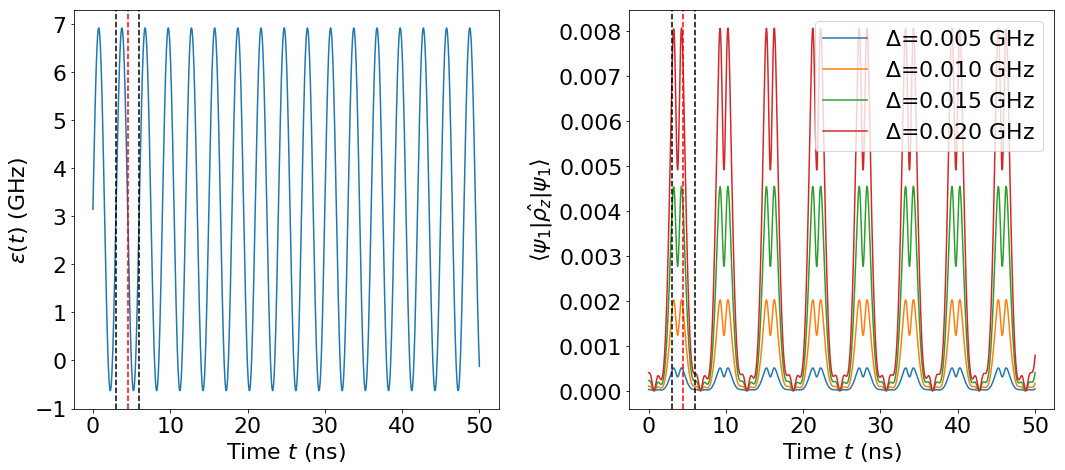

In [6]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# Epsilon term
ax1 = plt.subplot(121)
ax1.plot(times,epsilon(times,p))
ax1.axvline(x=2*np.pi/omega,ls="--",c="k")
ax1.axvline(x=3*np.pi/omega,ls="--",c="r")
ax1.axvline(x=4*np.pi/omega,ls="--",c="k")
#ax1.plot(xpts/tf_max,B(xpts,p))
ax1.set_xlabel('Time $t$ (ns)')
ax1.set_ylabel('$\epsilon (t)$ (GHz)')
#ax1.legend(("A(s)","B(s)"))

# Oscillations
ax2 = plt.subplot(122)
labels = []
for i in range(len(delta_vals)):
    ax2.plot(times, ypts[i])
    labels.append("$\\Delta$=%.3f GHz" % (delta_vals[i]/(2*np.pi)))
ax2.axvline(x=2*np.pi/omega,ls="--",c="k")
ax2.axvline(x=3*np.pi/omega,ls="--",c="r")
ax2.axvline(x=4*np.pi/omega,ls="--",c="k")
#ax2.plot(tf, pop0_ydm)
#ax2.plot(tf, pop0_xdm)
ax2.set_xlabel('Time $t$ (ns)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax2.legend(labels)

fig.tight_layout()

According to these results, the finite value of $\Delta$ causes incomplete deconstructive interference and also depends on when the pulse ends, much more sensitively than the resonant case.

#### Offset parameter

Now varying the offset parameter $\epsilon_0$ to cross multiples of the driving frequency should reveal peaks in the excited state probability, until $\epsilon_0 > A_\mathrm{RF}$:

In [7]:
# Hamiltonian parameters
delta0 = 0.02*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
epsilon_vals = np.linspace(0,5*np.pi,500)
ypts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/len(epsilon_vals)
for epsilon0 in epsilon_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    times = np.array([0,50.0])
    result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=5000))

    # Format data (get excited state probability)
    ypts.append(qt.expect(qt.ket2dm(zstates[1]),result.states[1]))
    
    # Update progress bar
    f.value += pb_d

Progress:


FloatProgress(value=0.0)

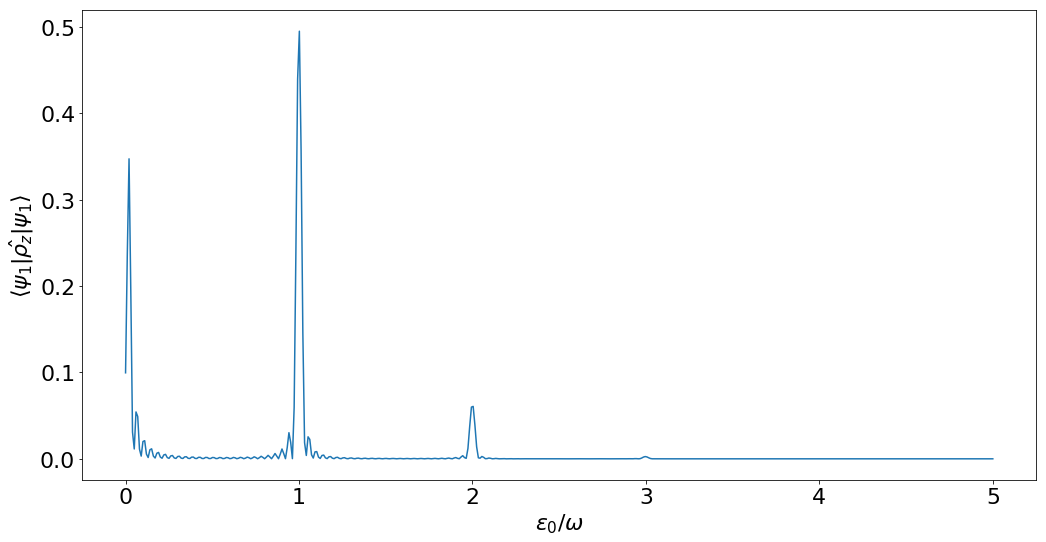

In [8]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,8))

# Oscillations
ax2 = plt.subplot(111)
ax2.plot(epsilon_vals/omega, ypts)
#ax2.plot(tf, pop0_zdm1)
#ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('$\epsilon_0/\omega$')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
#ax2.legend(["USC $<\hat{\\rho}_z>$","UCL $<\hat{\\rho}_z>$"])

fig.tight_layout()

### RF amplitude

Now varying the RF amplitude $A_\mathrm{RF}$:

In [9]:
# Hamiltonian parameters
delta0 = 0.02*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
Arf_vals = np.linspace(0,10*np.pi,500)
ypts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/len(Arf_vals)
for Arf in Arf_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    times = np.array([0,50.0])
    result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=5000))

    # Format data (get excited state probability)
    ypts.append(qt.expect(qt.ket2dm(zstates[1]),result.states[1]))
    
    # Update progress bar
    f.value += pb_d

Progress:


FloatProgress(value=0.0)

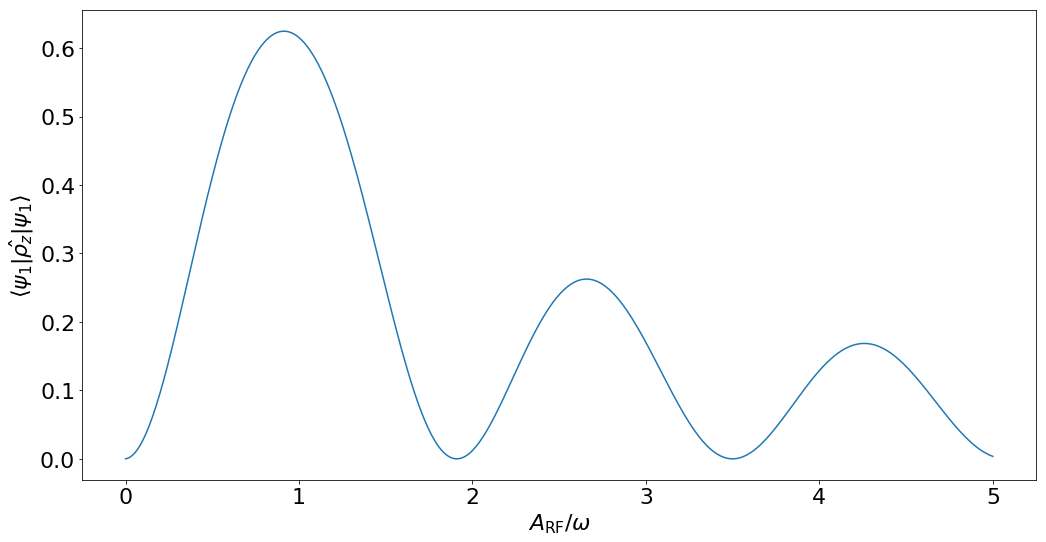

In [10]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,8))

# Oscillations
ax2 = plt.subplot(111)
ax2.plot(epsilon_vals/omega, ypts)
#ax2.plot(tf, pop0_zdm1)
#ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('$A_\mathrm{RF}/\omega$')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
#ax2.legend(["USC $<\hat{\\rho}_z>$","UCL $<\hat{\\rho}_z>$"])

fig.tight_layout()

As expected we find a Bessel-like dependence of the probability on the RF amplitude.

#### Parametric plot

Now we plot the probability as a function of the two control parameters $\varepsilon_0$ and $A_\mathrm{RF}$:

In [27]:
# Hamiltonian parameters
delta0 = 0.02*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
Arf_vals = np.linspace(0,10*np.pi,200)
epsilon_vals = np.linspace(0,3*np.pi,200)
zpts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(len(epsilon_vals)*len(Arf_vals))
for Arf in Arf_vals:
    zpts_p = []
    for epsilon0 in epsilon_vals:
        # Initial hamiltonian
        p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
        H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

        # Initial state
        Ei,psi_i = H0.eigenstates()
        E0 = Ei[0]
        psi0 = psi_i[0]

        # Hamiltonian definition
        H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

        # Solve time evolution for t >> 2pi/omega
        times = np.array([0,50.0])
        result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=5000))

        # Format data (get excited state probability)
        zpts_p.append(qt.expect(qt.ket2dm(zstates[1]),result.states[1]))
        
        # Update progress bar
        f.value += pb_d
    zpts.append(zpts_p)


Progress:


FloatProgress(value=0.0)

Done.


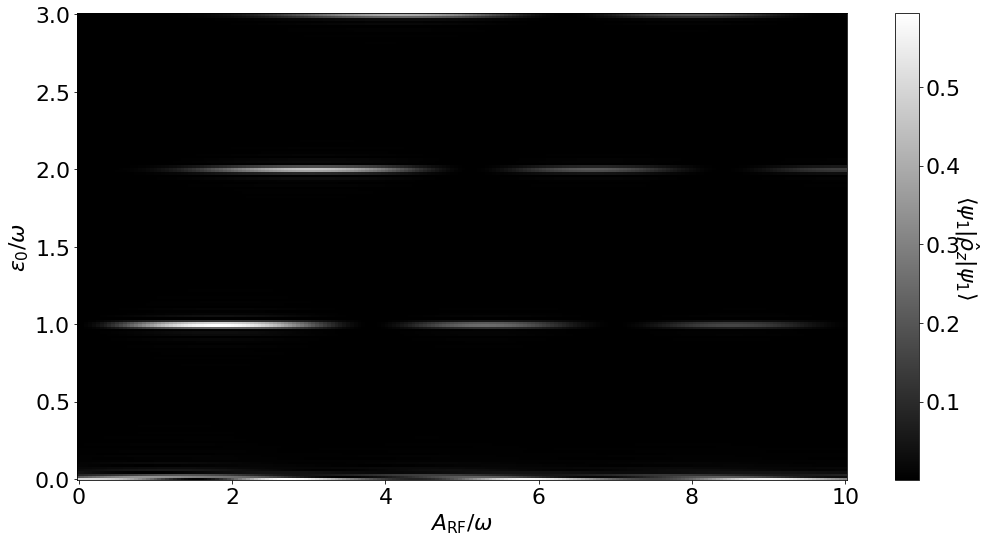

In [28]:
#
# Plot map function
#
# zdata is a list of lists:
#
#  If xdata and ydata have the same dimensions, ensure the zdata is properly formatted:
#  --
#
#  zdata = 
#  [ [z1,z2...], [z1,z2...] ]
#    |xvals...   |xvals...
#    yval1       yval2
#
#  ie:
#
#  zdata[yval_index][xval_index]
#
#  If xdata and ydata have different dimensions, the correct orientation of zdata is automagically determined.
#  --
#
#  figsize: x,y tuple in pixels (width,height)
#
def plot_map(xdata,xlabel,ydata,ylabel,zdata,zlabel,cmap='gray'):

    # Format data
    Xpts,Ypts,Zpts = np.array(xdata),np.array(ydata),np.array(zdata)

    # Data properties
    nx = Xpts.shape[0]
    ny = Ypts.shape[0]
    nz1 = Zpts.shape[0]
    nz2 = Zpts.shape[1]

    # Inverted case
    if nx == nz1 and ny == nz2 and not nx == ny:
        Zpts = Zpts.T
    Zpts = Zpts.T

    # Determine xstep and ystep (assumes linear increment)
    xs = np.abs(Xpts[0]-Xpts[1])
    ys = np.abs(Ypts[0]-Ypts[1])

    # Add the boundary point
    Xpts, Ypts = np.append(Xpts,Xpts[-1]+xs), np.append(Ypts,Ypts[-1]+ys)

    # Generate mesh
    X,Y = np.meshgrid(Xpts,Ypts)

    # Centre Z color quad coordinates
    X,Y = X-xs/2, Y-ys/2

    # Determine bounds for colorbar
    zmin, zmax = Zpts.min(), Zpts.max()

    # Get figure and axis object
    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(111)

    # Finish plot
    #fig.suptitle(title,size=titlefontsize)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xscale("linear")
    ax1.set_yscale("linear")
    mesh = ax1.pcolormesh(X,Y,Zpts,cmap=cmap,vmin=zmin, vmax=zmax)
    cbar = fig.colorbar(mesh)
    cbar.set_label(zlabel,rotation=-90,labelpad=20)
    fig.tight_layout()

# Plot map
plot_map(Arf_vals/omega,"$A_\mathrm{RF}/\omega$",epsilon_vals/omega,"$\epsilon_0/\omega$",zpts,"$\\langle\psi_1|\hat{\\rho}_z|\psi_1 \\rangle$")

The interference fringes are made very clear in this plot, the resonance condition

$$\varepsilon_0 = n\hbar \omega$$

can be clearly seen for $n=0,1,2,3...$. Furthermore we notice that constructive interference still occurs in the regime where

$$A_\mathrm{RF} \leq \varepsilon_0$$

### Large tunneling regime

Now we will look at the regime where $\Delta$ is comparable to the other energy scales of the system

$$\Delta \sim \omega, A_\mathrm{RF},\varepsilon_0$$

where we now expect the $\hat{\sigma}_z$ expectation values to evolve much more quickly.

#### Constructive and destructive interference

First looking at the case where

$$\omega \ll \Delta$$

we see that the system evolves much more quickly and thus the state vector follows the driving signal:

In [11]:
# Hamiltonian parameters
delta0 = np.pi
omega = 0.1*np.pi
epsilon0 = omega*1
Arf = 1.2*np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# Constructive
ypts_c = []
delta_vals = [0.5*2*np.pi,2*np.pi,1.5*2*np.pi,4*np.pi]

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(2*len(delta_vals))
times = np.linspace(0,50,1500)
for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts_c.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

# Destructive
epsilon0 = omega*1.5
ypts_d = []

for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts_d.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

Progress:


FloatProgress(value=0.0)

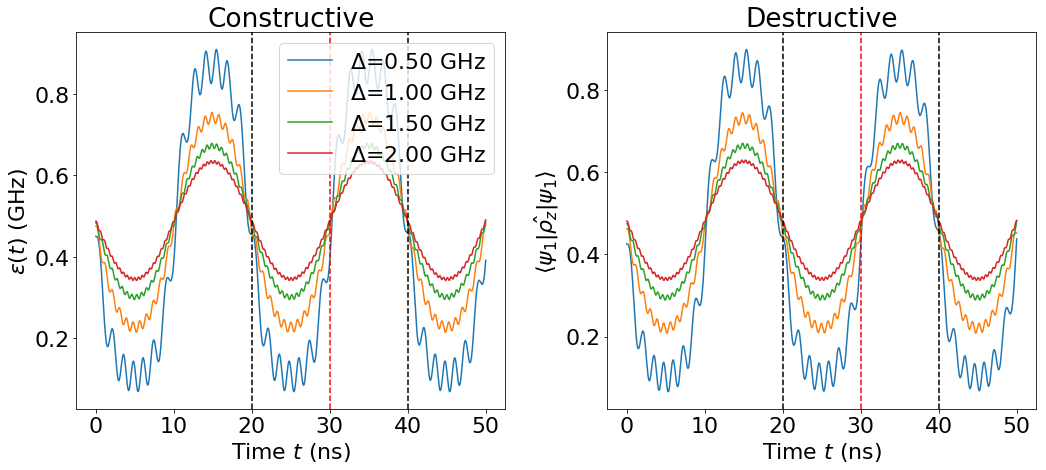

In [12]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# Epsilon term
ax1 = plt.subplot(121)
labels = []
for i in range(len(delta_vals)):
    ax1.plot(times, ypts_c[i])
    labels.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
ax1.axvline(x=2*np.pi/omega,ls="--",c="k")
ax1.axvline(x=3*np.pi/omega,ls="--",c="r")
ax1.axvline(x=4*np.pi/omega,ls="--",c="k")
ax1.set_xlabel('Time $t$ (ns)')
ax1.set_ylabel('$\epsilon (t)$ (GHz)')
ax1.set_title('Constructive')
ax1.legend(labels)

# Oscillations
ax2 = plt.subplot(122)
labels = []
for i in range(len(delta_vals)):
    ax2.plot(times, ypts_d[i])
    labels.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
ax2.axvline(x=2*np.pi/omega,ls="--",c="k")
ax2.axvline(x=3*np.pi/omega,ls="--",c="r")
ax2.axvline(x=4*np.pi/omega,ls="--",c="k")
ax2.set_xlabel('Time $t$ (ns)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax2.set_title('Destructive')
#ax2.legend(labels)

fig.tight_layout()

No constructive or destructive interference can be seen. My understanding is this is due to the LZ transition probability being much larger than in the small $\Delta$ case, and thus the transition almost always occurs and there is only one likely path the state vector will take, leading to negligible interference effects.

Now looking at the case where

$$\omega \sim \Delta$$

we see that the state vector struggles follow the driving signal and there is no observable interference effects:

In [13]:
# Hamiltonian parameters
delta0 = np.pi
omega = 0.5*np.pi
epsilon0 = omega*1
Arf = 1.2*np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# Constructive
ypts_c = []
delta_vals = [0.5*2*np.pi,2*np.pi,1.5*2*np.pi,4*np.pi]

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(2*len(delta_vals))
times = np.linspace(0,20,1500)
for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts_c.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

# Destructive
epsilon0 = omega*1.5
ypts_d = []

for delta0 in delta_vals:
    # Initial hamiltonian
    p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
    H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

    # Initial state
    Ei,psi_i = H0.eigenstates()
    E0 = Ei[0]
    psi0 = psi_i[0]

    # Hamiltonian definition
    H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

    # Solve time evolution for t >> 2pi/omega
    result = qt.mesolve(H, psi0, times, [], [], args=p)

    # Format data (get excited state probability)
    sz,zstates=qt.sigmaz().eigenstates()
    ypts_d.append([qt.expect(qt.ket2dm(zstates[1]),s) for s in result.states])
    
    # Update progress bar
    f.value += pb_d

Progress:


FloatProgress(value=0.0)

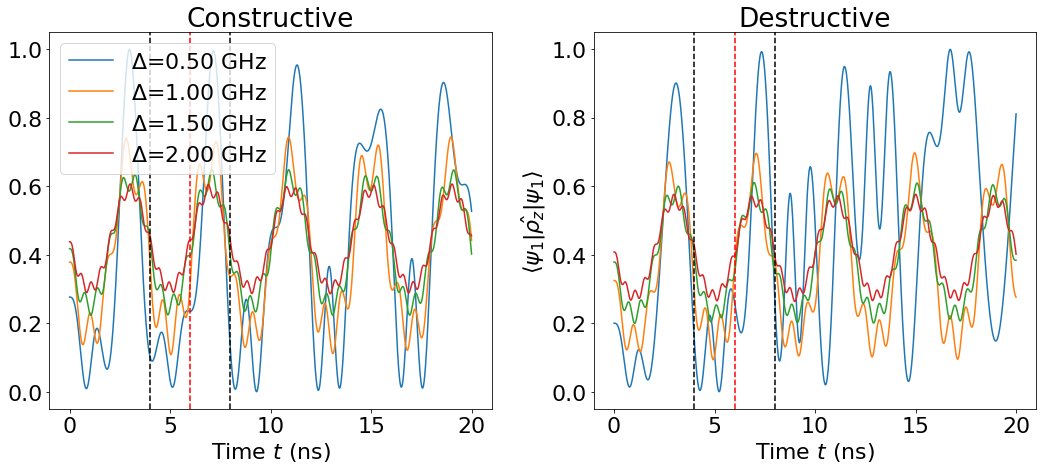

In [14]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,7))

# Epsilon term
ax1 = plt.subplot(121)
labels = []
for i in range(len(delta_vals)):
    ax1.plot(times, ypts_c[i])
    labels.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
ax1.axvline(x=2*np.pi/omega,ls="--",c="k")
ax1.axvline(x=3*np.pi/omega,ls="--",c="r")
ax1.axvline(x=4*np.pi/omega,ls="--",c="k")
ax1.set_xlabel('Time $t$ (ns)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax1.set_title('Constructive')
ax1.legend(labels)

# Oscillations
ax2 = plt.subplot(122)
labels = []
for i in range(len(delta_vals)):
    ax2.plot(times, ypts_d[i])
    labels.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
ax2.axvline(x=2*np.pi/omega,ls="--",c="k")
ax2.axvline(x=3*np.pi/omega,ls="--",c="r")
ax2.axvline(x=4*np.pi/omega,ls="--",c="k")
ax2.set_xlabel('Time $t$ (ns)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax2.set_title('Destructive')
#ax2.legend(labels)

fig.tight_layout()

Vary the drive frequency for a range of tunneling amplitudes:

In [19]:
# Hamiltonian parameters
delta0 = 0.02*np.pi
epsilon0 = np.pi
Arf = 1.2*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.sin(p["w"]*t)
def delta(t,p):
    return p["d0"]

# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
delta_vals = [0.02*np.pi,0.05*np.pi,0.1*np.pi,0.2*np.pi,0.5*np.pi]
w_vals = np.linspace(0.1*np.pi,4*np.pi,500)
ypts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(len(w_vals)*5)
for delta0 in delta_vals:
    ypts_t = []
    for omega in w_vals:
        # Initial hamiltonian
        p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
        H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

        # Initial state
        Ei,psi_i = H0.eigenstates()
        E0 = Ei[0]
        psi0 = psi_i[0]

        # Hamiltonian definition
        H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

        # Solve time evolution for t >> 2pi/omega
        times = np.array([0,50.0])
        result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=7000))

        # Format data (get excited state probability)
        ypts_t.append(qt.expect(qt.ket2dm(zstates[1]),result.states[1]))

        # Update progress bar
        f.value += pb_d
    ypts.append(ypts_t)

Progress:


FloatProgress(value=0.0)

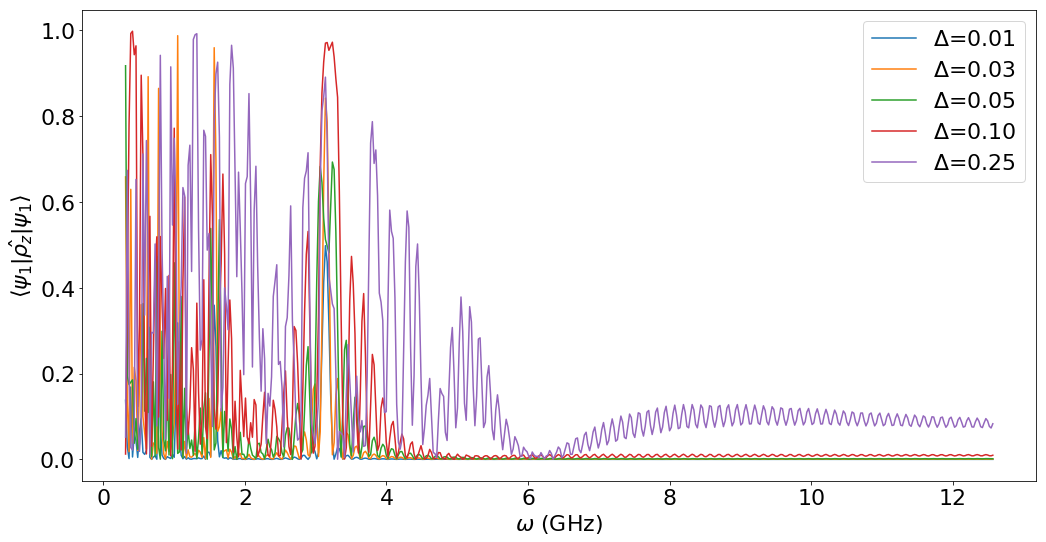

In [20]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,8))

# Oscillations
ax2 = plt.subplot(111)
leg = []
for i in range(len(delta_vals)):
    ax2.plot(w_vals, ypts[i])
    leg.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
#ax2.plot(tf, pop0_zdm1)
#ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('$\omega$ (GHz)')
ax2.set_ylabel('$\\langle\psi_1|\hat{\\rho_z}|\psi_1 \\rangle$')
ax2.legend(leg)

fig.tight_layout()

Now looking at a situation that is similar to the UCL reverse-forward annealing protocol:

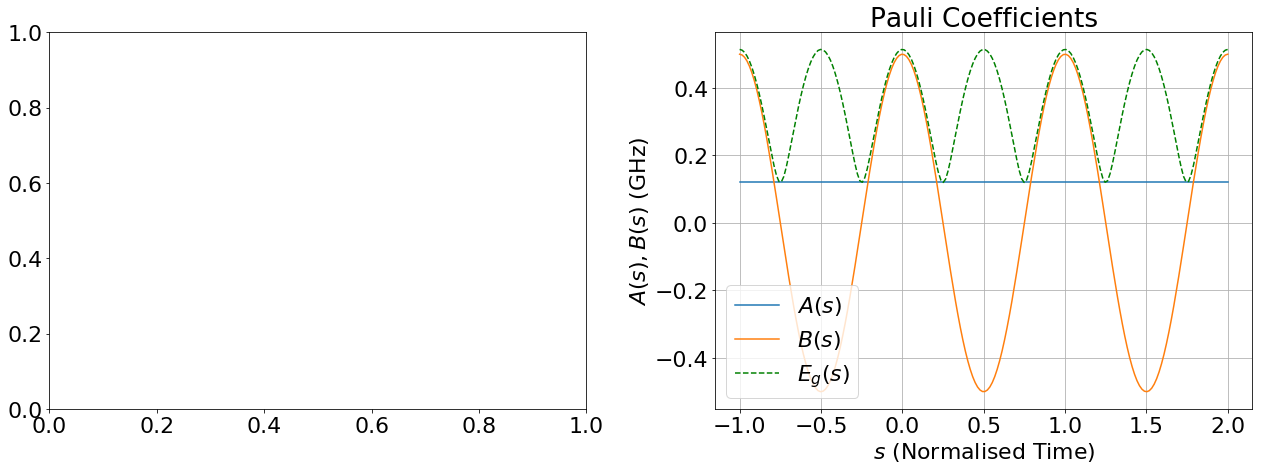

In [54]:
# Hamiltonian parameters
delta0 = 0.24*np.pi
epsilon0 = np.pi*0
Arf = 1.0*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.cos(p["w"]*t)
def delta(t,p):
    return p["d0"]+0*t

# Params
p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}

# Get points over one period
tau = 2*np.pi/omega
tpts = np.linspace(-tau,2*tau,200)
Apts = delta(tpts,p)
Bpts = epsilon(tpts,p)

# Plot the spectrum
# Phase schedules
fig = plt.figure(figsize=(18,7))
ax11 = plt.subplot(121)

# Energy schedules
ax2 = plt.subplot(122)
ax2.plot(tpts/tau, Apts/(2*np.pi))
ax2.plot(tpts/tau, Bpts/(2*np.pi))
ax2.plot(tpts/tau,np.sqrt(Apts**2 + Bpts**2)/(2*np.pi),"g--")
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('$A(s),B(s)$ (GHz)')
ax2.legend(["$A(s)$","$B(s)$","$E_g(s)$"])
ax2.grid()
fig.tight_layout()

In [50]:
# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
delta_vals = [0.24*np.pi,0.48*np.pi,0.72*np.pi,0.96*np.pi]
tan_vals = np.linspace(0.001,30,400)
ypts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(len(tan_vals)*len(delta_vals))
for delta0 in delta_vals:
    ypts_t = []
    for tan in tan_vals:
        
        # Get drive frequency
        omega = 2*np.pi/tan
        
        # Initial hamiltonian
        p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
        H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

        # Initial state
        Ei,psi_i = H0.eigenstates()
        E0 = Ei[0]
        psi0 = psi_i[0]

        # Hamiltonian definition
        H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

        # Solve time evolution for t >> 2pi/omega
        times = np.array([0,tan])
        result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=7000))

        # Format data (get excited state probability)
        ypts_t.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))

        # Update progress bar
        f.value += pb_d
    ypts.append(ypts_t)

Progress:


FloatProgress(value=0.0)

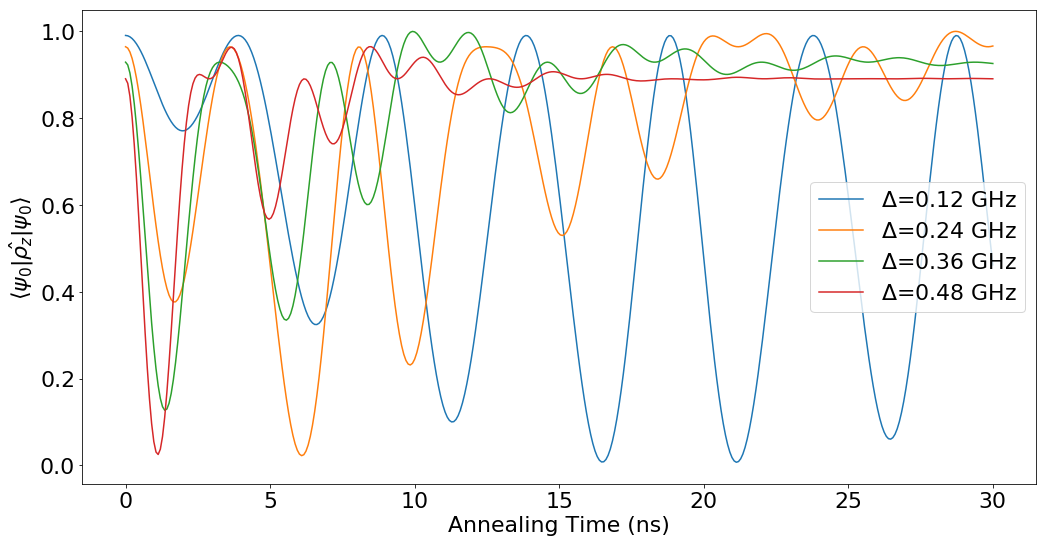

In [52]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(15,8))

# Oscillations
ax2 = plt.subplot(111)
leg = []
for i in range(len(delta_vals)):
    ax2.plot(tan_vals, ypts[i])
    leg.append("$\\Delta$=%.2f GHz" % (delta_vals[i]/(2*np.pi)))
#ax2.plot(tf, pop0_zdm1)
#ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('Annealing Time (ns)')
ax2.set_ylabel('$\\langle\psi_0|\hat{\\rho_z}|\psi_0 \\rangle$')
ax2.legend(leg)

fig.tight_layout()